# Introduction

<div class="alert alert-block alert-warning">
<font color=black><br>

**What?** How to opptimise scikit-learn execution  time

<br></font>
</div>

# What options do we have?

<div class="alert alert-block alert-info">
<font color=black><br>

- **Option #1** = Changing your optimization function (solver)
- **Option #2** = Using different hyperparameter optimization techniques (grid search, random search, early stopping)
- **Option #3** = Parallelize or distribute your training with joblib and Ray


<br></font>
</div>

# Import modules

In [30]:
import time
from IPython.display import Markdown
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tune_sklearn import TuneGridSearchCV
from sklearn.model_selection import GridSearchCV
import numpy as np
import time
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings("ignore")

# Helper function

In [21]:
def myPrint(string, c = "blue"):    
    """My version of the python-native print command.
    
    Print in bold and red tect
    """
    colorstr = "<span style='color:{}'>{}</span>".format(c, '**'+ string + '**' )    
    display(Markdown(colorstr))

# Option #1 - Changing optimisation solver

<div class="alert alert-block alert-info">
<font color=black><br>

- A **full gradient** algorithm (liblinear) converges rapidly, but each iteration can be prohibitively costly because it requires you to use all of the data. 
- A **sub-sampled** approach each iteration is cheap to compute, but it can converge much more slowly. 
- **Saga** algorithms achieve the best of both worlds. Each iteration is cheap to compute, and the algorithm converges rapidly because of a variance reduction technique. 
- It is important to note that quick convergence doesn’t always matter in practice and different solvers suit different problems.


- The we are performing below shows that the results depends on the sample size.

<br></font>
</div>

In [22]:
# Solvers
solvers = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
samples = [1000, 10000, 100000]

for sample in samples:
    print("=====================")
    print("Sample size: ", sample)
    X, y = make_classification(n_samples=sample, n_features=int(0.01*sample), n_classes = 2)

    # Set training and validation sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = int(0.1*sample))

    bestTime = 1.e6
    bestSolver = "dummy"
    for sol in solvers: 
        print("Currently using solver: ", sol)
        start = time.time()
        logreg = LogisticRegression(solver=sol)
        logreg.fit(X_train, y_train)
        end = time.time()
        print(sol + " Fit Time: ",end-start)
        if end-start < bestTime:
            bestSolver = sol
            bestTime = end-start

        if sol == solvers[-1]:
            myPrint("Best:--->" + bestSolver)

Sample size:  1000
Currently using solver:  newton-cg
newton-cg Fit Time:  0.011873960494995117
Currently using solver:  lbfgs
lbfgs Fit Time:  0.006147146224975586
Currently using solver:  liblinear
liblinear Fit Time:  0.0023097991943359375
Currently using solver:  sag
sag Fit Time:  0.005433797836303711
Currently using solver:  saga
saga Fit Time:  0.004868984222412109


<span style='color:blue'>**Best:--->liblinear**</span>

Sample size:  10000
Currently using solver:  newton-cg
newton-cg Fit Time:  0.1018209457397461
Currently using solver:  lbfgs
lbfgs Fit Time:  0.028445959091186523
Currently using solver:  liblinear
liblinear Fit Time:  0.14489078521728516
Currently using solver:  sag
sag Fit Time:  0.3560481071472168
Currently using solver:  saga
saga Fit Time:  0.17046594619750977


<span style='color:blue'>**Best:--->lbfgs**</span>

Sample size:  100000
Currently using solver:  newton-cg
newton-cg Fit Time:  14.735826969146729
Currently using solver:  lbfgs
lbfgs Fit Time:  1.2944860458374023
Currently using solver:  liblinear
liblinear Fit Time:  8.620182991027832
Currently using solver:  sag
sag Fit Time:  38.33187198638916
Currently using solver:  saga
saga Fit Time:  15.503754138946533


<span style='color:blue'>**Best:--->lbfgs**</span>

# Option #2 = Using different hyperparameter optimization techniques 

<div class="alert alert-block alert-info">
<font color=black><br>

- GridSearchCV and RandomizedSearchCV are all good old options but the newly added HalvingGridSearchCV and HalvingRandomSearch are even better especially for saving in time they offer.
- While these new techniques are exciting, there is a library called **Tune-sklearn** that provides cutting edge hyperparameter tuning techniques (bayesian optimization, early stopping, and distributed execution) that can provide significant speedups over grid search and random search.
- There is  support also for Skorch (PyTorch), KerasClassifiers (Keras), and XGBoostClassifiers (XGBoost).
- Scalability: The library leverages **Ray Tune**, a library for distributed hyperparameter tuning, to efficiently and transparently parallelize cross validation on multiple cores and even multiple machines.


- We'll show here a simple examples withL
    - `from tune_sklearn import TuneGridSearchCV`
    - `from sklearn.model_selection import GridSearchCV`

<br></font>
</div>

**Dataset and hyperparameter space**

In [ ]:
# Set training and validation sets
X, y = make_classification(n_samples=11000, n_features=1000, n_informative=50, n_redundant=0, n_classes=10, class_sep=2.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000)

# Example parameters to tune from SGDClassifier
parameters = {
    'alpha': [1e-4, 1e-1, 1],
    'epsilon':[0.01, 0.1]
}

**Tune-skleanr**

In [33]:
tune_search = TuneGridSearchCV(
    SGDClassifier(),
    parameters,
    early_stopping="MedianStoppingRule",
    max_iters=10
)

start = time.time()
tune_search.fit(X_train, y_train)
end = time.time()
print("Tune Fit Time:", end - start)
pred = tune_search.predict(X_test)
accuracy = np.count_nonzero(np.array(pred) == np.array(y_test)) / len(pred)
print("Tune Accuracy:", accuracy)


File descriptor limit 256 is too low for production servers and may result in connection errors. At least 8192 is recommended. --- Fix with 'ulimit -n 8192'
(raylet) /Users/gmura/anaconda3/envs/trainingAI/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(


Tune Fit Time: 26.745426177978516
Tune Accuracy: 0.876


**sklearn**

In [25]:
# n_jobs=-1 enables use of all cores like Tune does
sklearn_search = GridSearchCV(
    SGDClassifier(),
    parameters,
    n_jobs = -1
)

start = time.time()
sklearn_search.fit(X_train, y_train)
end = time.time()
print("Sklearn Fit Time:", end - start)
pred = sklearn_search.predict(X_test)
accuracy = np.count_nonzero(np.array(pred) == np.array(y_test)) / len(pred)
print("Sklearn Accuracy:", accuracy)

Sklearn Fit Time: 58.697211027145386
Sklearn Accuracy: 0.867


# Option #3 = Parallelize or distribute your training with joblib and Ray

<div class="alert alert-block alert-info">
<font color=black><br>

- Another way to increase your model building speed is to parallelize or distribute your training with joblib and Ray. By **default**, scikit-learn trains a model using a single core. 
- It is important to note that virtually all computers today have multiple cores. 
- Scikit-Learn can parallelize training on a single node with joblib which by default uses the **loky** backend. Joblib allows you to choose between backends like ‘loky’, ‘multiprocessing’, ‘dask’, and ‘ray’. This is a great feature as the ‘loky’ backend is optimized for a single node and not for running distributed (multinode) applications.

<br></font>
</div>

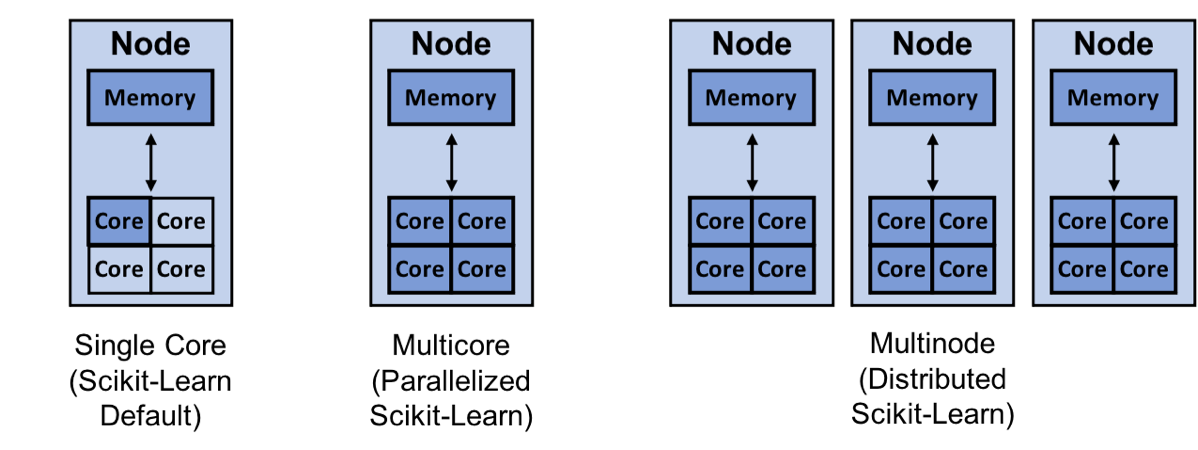

<div class="alert alert-block alert-info">
<font color=black><br>

-  Running distributed applications can introduce a host of complexities like:
    - Scheduling tasks across multiple machines
    - Transferring data efficiently
    - Recovering from machine failures
- Ray backend can handle these details for you, keep things simple, and give you better performance.

<br></font>
</div>

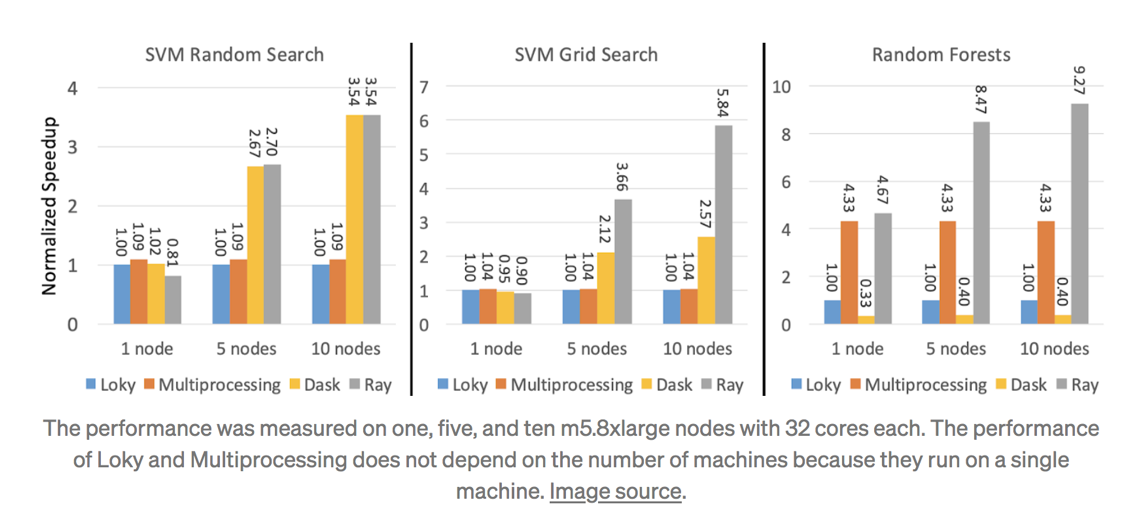

# References

<div class="alert alert-block alert-warning">
<font color=black><br>

- [Article](https://medium.com/distributed-computing-with-ray/how-to-speed-up-scikit-learn-model-training-aaf17e2d1e1)
- [Code on changing solvers](https://gist.github.com/mGalarnyk/f42f434fc162be108a3bb5bc36464a59) 
- [Examples of how to use tune-sklearn]()https://github.com/ray-project/tune-sklearn/tree/master/examples
<br></font>
</div>